# Reading NEHX trees into matrices 


In [5]:
from Bio import Phylo
from io import StringIO
import pandas as pd
import numpy as np
import h5py
from scipy.sparse import csr_matrix, save_npz
import os
import sys


In [6]:
import pandas as pd
species_id = pd.read_csv("species_id.csv", header=None, index_col=1)
species_id.columns = ["species"]
species_id.index.name = "id"

species_id_dict = species_id.to_dict()
species_id_dict = species_id_dict["species"]
# species_id_dict

In [11]:
def get_ancestors(node, species_name, matrix, row, col, adjacency_df):
    try:
        ancestor = adjacency_df.loc[adjacency_df[node] == 1].index[0]
    except:
        ancestor = None
    if ancestor != None:
        matrix[row.index(ancestor), col.index(species_name)] = 1
        return get_ancestors(ancestor, species_name, matrix, row, col, adjacency_df)

In [40]:
# i feel like you don't need to store data, since it's all 1's

def create_h5_file(matrix, matrix_name, output_dir, count, row, column=""):
    with h5py.File(f"{output_dir}/{matrix_name}_{count}.h5", "w") as f:
        matrix_sparse = csr_matrix(matrix)
        # f.create_dataset(f'{matrix_name}_data', data=matrix_sparse.data, compression="gzip", compression_opts=9)
        f.create_dataset(f'{matrix_name}_indices', data=matrix_sparse.indices, compression="gzip", compression_opts=9)
        f.create_dataset(f'{matrix_name}_indptr', data=matrix_sparse.indptr, compression="gzip", compression_opts=9)
        f.create_dataset(f'{matrix_name}_shape', data=matrix_sparse.shape, compression="gzip", compression_opts=9)
        f.create_dataset(f'{matrix_name}_rows', data=np.array(row, dtype='S'), compression="gzip", compression_opts=9)
        if column:
            f.create_dataset(f'{matrix_name}_columns', data=np.array(column, dtype='S'), compression="gzip", compression_opts=9)


In [41]:
def create_matrices(tree_str, species_id_dict, count=1, print_tree=False, save_files=False, output_dir="."):
    # tic = time.perf_counter()
    tree = Phylo.read(StringIO(tree_str), "newick")
    node = 0
    num_nodes = 0
    internal_nodes = 0
    terminal_nodes = 0
    event_row = []
    species_row = [] # ids 
    species_col = [] # names
    species_internal_row = []
    
    # initialize events, species, and adjacency matrix
    for clade in tree.find_clades():
        num_nodes += 1
        if clade.name == None:
            clade.name = str(internal_nodes)
            internal_nodes += 1
            species_internal_row.append(clade.name)
        else:
            terminal_nodes += 1
            species_row.append(clade.name)
            try:
                species_name = species_id_dict[clade.name]
            except:
                species_name = clade.name
            species_col.append(species_name)
        event_row.append(clade.name)
        
    event_columns = ["leaf", "duplication", "speciation"]
    events = np.zeros((num_nodes, 3))
    species = np.zeros((terminal_nodes, len(species_row))) 
    # adjacency matrix
    parent = event_row.copy()
    adjacency = np.zeros((len(parent), len(parent)))
    # internal - species matrix
    species_internal = np.zeros((internal_nodes, len(species_row)))

    # fill out matrices
    for clade in tree.find_clades():
        if ':[' in clade.name:
            name, nhx_string = clade.name.split(':[')
            nhx_tags = nhx_string.rstrip(']').split(':')
            nhx_data = {}
            for tag in nhx_tags:
                key, value = tag.split('=')
                nhx_data[key] = value
            clade.name = name
            clade.comment = str(nhx_data)

        # Event matrix
        # row = node, column = event type
        if str(clade.name).isdigit(): # internal node
            if "D=Y" in clade.comment: # duplication
                events[node] = [0, 1, 0]
            elif "D=N" in clade.comment: # speciation
                events[node] = [0, 0, 1]
            else: # idk, throw a warning?
                break
        else: # leaf node
            events[node] = [1, 0, 0]

        # Species matrix
        # row = species, column = species name
        if clade.name in species_row:
            try:
                species_name = species_id_dict[clade.name]
                species[species_row.index(clade.name), species_col.index(species_name)] = 1
            except:
                pass # species isn't defined in SEQ, will not have entry in species, [FIX LATER]            
        node += 1
    # Adjacency matrix
    # row = parent, column = child
    for clade in tree.get_nonterminals():
        parent_node = clade.name
        children = [child.name for child in clade.clades]
        for child in children:
            adjacency[parent.index(parent_node), parent.index(child)] = 1

    # Fill out species-internal node matrix
    # row = internal node, column = species
    adjacency_df = pd.DataFrame(adjacency, index=parent, columns=parent)
    for leaf in tree.get_terminals():
        species_name = species_id_dict[leaf.name]
        get_ancestors(leaf.name, species_name, species_internal, species_internal_row, species_col, adjacency_df)
    
    # Draw tree
    # add speciation / duplication events
    if print_tree:
        # for clade in tree.find_clades():
        #     if clade.name.isdigit():
        #         if "D=Y" in clade.comment:
        #             clade.name += "(D)"
        #         elif "D=N" in clade.comment:
        #             clade.name += "(S)"
        Phylo.draw(tree)
                
    if save_files:
        if not os.path.exists(f"{output_dir}/"):
            os.makedirs(f"{output_dir}/")
        create_h5_file(events, "events", output_dir, count, event_row, event_columns)
        create_h5_file(species, "species", output_dir, count, species_row, species_col)
        create_h5_file(adjacency, "adjacency", output_dir, count, parent)
        create_h5_file(species_internal, "species_internal", output_dir, count, species_internal_row)

        # with h5py.File(f"{output_dir}/event_{count}.h5", "w") as f:
        #     event_sparse = csr_matrix(events)
        #     f.create_dataset('events_data', data=event_sparse.data, compression="gzip", compression_opts=9)
        #     f.create_dataset('events_indices', data=event_sparse.indices, compression="gzip", compression_opts=9)
        #     f.create_dataset('events_indptr', data=event_sparse.indptr, compression="gzip", compression_opts=9)
        #     f.create_dataset('events_shape', data=event_sparse.shape, compression="gzip", compression_opts=9)
        #     f.create_dataset("event_rows", data=np.array(event_row, dtype='S'), compression="gzip", compression_opts=9)
        #     f.create_dataset("event_columns", data=np.array(event_columns, dtype='S'), compression="gzip", compression_opts=9)

        # with h5py.File(f"{output_dir}/species_{count}.h5", "w") as f:
        #     species_sparse = csr_matrix(species)
        #     f.create_dataset('species_data', data=species_sparse.data, compression="gzip", compression_opts=9)
        #     f.create_dataset('species_indices', data=species_sparse.indices, compression="gzip", compression_opts=9)
        #     f.create_dataset('species_indptr', data=species_sparse.indptr, compression="gzip", compression_opts=9)
        #     f.create_dataset('species_shape', data=species_sparse.shape, compression="gzip", compression_opts=9)
        #     f.create_dataset("species_rows", data=np.array(species_row, dtype='S'), compression="gzip", compression_opts=9)
        #     f.create_dataset("species_columns", data=np.array(species_col, dtype='S'), compression="gzip", compression_opts=9)
                
        # with h5py.File(f"{output_dir}/adjacency_{count}.h5", "w") as f:
        #     adjacency_sparse = csr_matrix(adjacency)
        #     f.create_dataset('adjacency_data', data=adjacency_sparse.data, compression="gzip", compression_opts=9)
        #     f.create_dataset('adjacency_indices', data=adjacency_sparse.indices, compression="gzip", compression_opts=9)
        #     f.create_dataset('adjacency_indptr', data=adjacency_sparse.indptr, compression="gzip", compression_opts=9)
        #     f.create_dataset('adjacency_shape', data=adjacency_sparse.shape, compression="gzip", compression_opts=9)
        #     f.create_dataset("parent", data=np.array(parent, dtype='S'), compression="gzip", compression_opts=9)
        #     # f.create_dataset("child", data=np.array(parent, dtype='S'), compression="gzip", compression_opts=9)

        # with h5py.File(f"{output_dir}/species_internal_{count}.h5", "w") as f:
        #     species_internal_sparse = csr_matrix(species_internal)
        #     f.create_dataset('species_internal_data', data=species_internal_sparse.data, compression="gzip", compression_opts=9)
        #     f.create_dataset('species_internal_indices', data=species_internal_sparse.indices, compression="gzip", compression_opts=9)
        #     f.create_dataset('species_internal_indptr', data=species_internal_sparse.indptr, compression="gzip", compression_opts=9)
        #     f.create_dataset('species_internal_shape', data=species_internal_sparse.shape, compression="gzip", compression_opts=9)
        #     f.create_dataset("species_internal_row", data=np.array(species_internal_row, dtype='S'), compression="gzip", compression_opts=9)'

        # print(f"Saving files: {toc - tic:0.4f} seconds")

    # npz files
    # if save_files:
    #     if not os.path.exists(f"{output_dir}/"):
    #         os.makedirs(f"{output_dir}/")
    #     event_sparse = csr_matrix(events)        
    #     save_npz(f'{output_dir}/events.npz', event_sparse)
    #     np.save(f'{output_dir}/event_row.npy', event_row)
    #     np.save(f'{output_dir}/event_columns.npy', event_columns)

    #     species_sparse = csr_matrix(species)        
    #     save_npz(f'{output_dir}/species.npz', species_sparse)
    #     np.save(f'{output_dir}/species_row.npy', species_row)
    #     np.save(f'{output_dir}/species_columns.npy', species_col)

    #     adjacency_sparse = csr_matrix(adjacency)        
    #     save_npz(f'{output_dir}/adjacency.npz', adjacency_sparse)
    #     np.save(f'{output_dir}/adjacency_indices.npy', parent)
    #     # np.save(f'{output_dir}/adjacency_columns.npy', child)

    else:
        return tree, events, event_row, event_columns, species, species_row, species_col, species_internal, species_internal_row, adjacency, parent
    

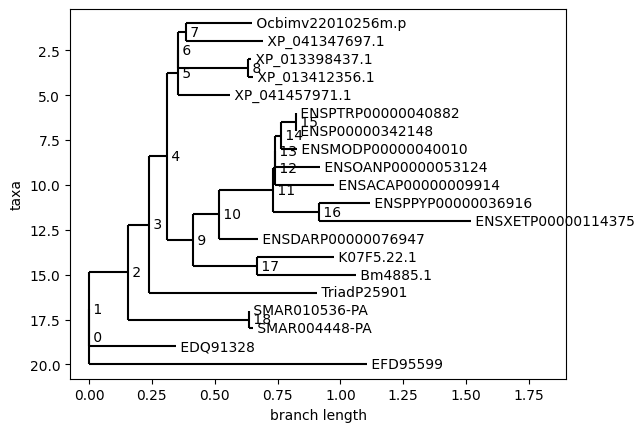

In [42]:
tree_str = "((((((((Ocbimv22010256m.p:0.26104[&&NHX:D=N:G=Ocbimv22010256m.g:T=37653],XP_041347697.1:0.305446[&&NHX:D=N:G=LOC121367533:T=1735272]):0.032711[&&NHX:D=N:B=0:T=6447],(XP_013398437.1:0.012456[&&NHX:D=N:G=LOC106164934:T=7574],XP_013412356.1:0.017599[&&NHX:D=N:G=LOC106175080:T=7574]):0.278993[&&NHX:D=Y:B=100:T=7574]):0[&&NHX:D=N:B=0:T=1206795],XP_041457971.1:0.207729[&&NHX:D=N:G=LOC121410147:T=7654]):0.046033[&&NHX:D=N:B=20:T=33213],(((((((ENSPTRP00000040882:0[&&NHX:D=N:G=ENSPTRG00000001040:T=9598],ENSP00000342148:0[&&NHX:D=N:G=ENSG00000215717:T=9606]):0.060272[&&NHX:D=N:B=100:T=207598],ENSMODP00000040010:0.067199[&&NHX:D=N:G=ENSMODG00000028749:T=13616]):0.020318[&&NHX:D=N:B=84:T=32525],ENSOANP00000053124:0.176689[&&NHX:D=N:G=ENSOANG00000042071:T=9258]):0.003495[&&NHX:D=N:B=73:T=40674],ENSACAP00000009914:0.237724[&&NHX:D=N:G=ENSACAG00000010122:T=28377]):0.008001[&&NHX:D=N:B=75:T=32524],(ENSPPYP00000036916:0.202782[&&NHX:D=N:G=ENSPPYG00000039113:T=9601],ENSXETP00000114375:0.60199[&&NHX:D=N:G=ENSXETG00000008004:T=8364]):0.186174[&&NHX:D=N:B=84:T=32523]):0.213378[&&NHX:DD=Y:B=37:T=32523],ENSDARP00000076947:0.155851[&&NHX:D=N:G=ENSDARG00000059400:T=7955]):0.101623[&&NHX:D=N:B=38:T=117571],(K07F5.22.1:0.308208[&&NHX:D=N:G=WBGene00303023:T=6239],Bm4885.1:0.393611[&&NHX:D=N:G=WBGene00225146:T=6279]):0.251722[&&NHX:D=N:B=94:T=6236]):0.106466[&&NHX:D=N:B=21:T=33213]):0.070302[&&NHX:DD=Y:B=8:T=33213],TriadP25901:0.66703[&&NHX:D=N:G=TriadG25901:T=10228]):0.084022[&&NHX:D=N:B=2:T=6072],(SMAR010536-PA:0.001149[&&NHX:D=N:G=SMAR010536:T=126957],SMAR004448-PA:0.014142[&&NHX:D=N:G=SMAR004448:T=126957]):0.482817[&&NHX:D=Y:B=100:T=126957]):0.154171[&&NHX:DD=Y:B=2:T=6072],EDQ91328:0.346481[&&NHX:D=N:G=MONBRDRAFT_14967:T=431895]):0[&&NHX:D=N:B=45:T=33154],EFD95599:1.1044[&&NHX:D=N:G=GL50803_34850:T=184922]):0[&&NHX:D=N:B=0:T=2759];"

# tree, events, event_row, event_columns, species, species_row, species_col, species_internal, species_internal_row, adjacency, parent = create_matrices(tree_str, species_id_dict, print_tree=True, save_files=False, output_dir="./out")
create_matrices(tree_str, species_id_dict, print_tree=True, save_files=True, output_dir="./out")

# 0.8 seconds (if not saving file)
# 1.0 seconds (if saving file)

In [91]:
import h5py

def print_h5py_file(filename, matrix_name):
    cols = []
    with h5py.File(filename, "r") as f:
        # matrix = np.array(f[f"{matrix_name}_data"])
        indices = np.array(f[f"{matrix_name}_indices"])
        indptr = np.array(f[f"{matrix_name}_indptr"])
        rows = np.array(f[f"{matrix_name}_rows"]).astype('S').astype('U')  
        if matrix_name == "species":
            cols = np.array(f[f"{matrix_name}_columns"]).astype('S').astype('U')  
    # return matrix, indices, indptr, rows, cols
    if matrix_name == "events":
        cols = ["leaf", "duplication", "speciation"]
    elif matrix_name == "adjacency":
        cols = rows
    if matrix_name != "species-internal": # i'll do this later
        df = pd.DataFrame(0, index=rows, columns=cols)
        for i, j in zip(indices, indptr):
            df.loc[rows[j], cols[i]] = 1

    return df, indices, indptr, rows, cols

# e_matrix, e_index, e_indptr, e_rows, e_cols = print_h5py_file("out/events_1.h5", "events", "events_rows", "events_columns")
# a_matrix, a_index, a_indptr, a_rows, a_cols = print_h5py_file("out/adjacency_1.h5", "adjacency", "adjacency_rows")
# s_matrix, s_index, s_indptr, s_rows, s_cols = print_h5py_file("out/species_1.h5", "species", "species_rows", "species_columns")
# i_matrix, i_index, i_indptr, i_rows, i_cols = print_h5py_file("out/species_internal_1.h5", "species_internal", "species_internal_rows")

e_df ,e_index, e_indptr, e_rows, e_cols = print_h5py_file("out/events_1.h5", "events")
a_df, a_index, a_indptr, a_rows, a_cols = print_h5py_file("out/adjacency_1.h5", "adjacency")
s_df, s_index, s_indptr, s_rows, s_cols = print_h5py_file("out/species_1.h5", "species")
# i_index, i_indptr, i_rows, i_cols = print_h5py_file("out/species_internal_1.h5", "species_internal")
a_df

,0,1,2,3,4,5,6,7,Ocbimv22010256m.p,XP_041347697.1,...,ENSDARP00000076947,17,K07F5.22.1,Bm4885.1,TriadP25901,18,SMAR010536-PA,SMAR004448-PA,EDQ91328,EFD95599
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Ocbimv22010256m.p,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
XP_041347697.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [84]:
s_index, s_indptr, s_rows, s_cols 

(array([ 0,  1,  2,  2,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        16, 18, 19]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]),
 array([b'Ocbimv22010256m.p', b'XP_041347697.1', b'XP_013398437.1',
        b'XP_013412356.1', b'XP_041457971.1', b'ENSPTRP00000040882',
        b'ENSP00000342148', b'ENSMODP00000040010', b'ENSOANP00000053124',
        b'ENSACAP00000009914', b'ENSPPYP00000036916',
        b'ENSXETP00000114375', b'ENSDARP00000076947', b'K07F5.22.1',
        b'Bm4885.1', b'TriadP25901', b'SMAR010536-PA', b'SMAR004448-PA',
        b'EDQ91328', b'EFD95599'], dtype='|S18'),
 [])

In [75]:
print(i_index, i_indptr)
# create dataframe of size len(rows) x len(cols) and fill in 1's at indices
e_cols = ["leaf", "duplication", "speciation"]
e_rows_str = [i.decode("utf-8") for i in e_rows]

e_df = pd.DataFrame(0, index=e_rows_str, columns=e_cols)
for i, j in zip(e_index, e_indptr):
    e_df.loc[e_rows_str[j], e_cols[i]] = 1
e_df

[ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19  0  1  2  4  5  6
  7  8  9 10 11 12 13 14 15 16 18  0  1  2  4  5  6  7  8  9 10 11 12 13
 14 15 16  0  1  2  4  5  6  7  8  9 10 11 12 13 14 15  0  1  2  4  5  6
  7  8  9 10 11 12 13 14  0  1  2  4  0  1  2  0  1  2  5  6  7  8  9 10
 11 12 13 14  5  6  7  8  9 10 11 12  5  6  7  8  9 10 11  5  6  7  8  9
  5  6  7  8  5  6  7  5  6 10 11 13 14 16] [  0  18  35  51  66  80  84  87  89  90 100 108 115 120 124 127 129 131
 133 134]


,leaf,duplication,speciation
0,0,0,1
1,0,0,1
2,0,1,0
3,0,0,1
4,0,1,0
5,0,0,1
6,0,0,1
7,0,0,1
Ocbimv22010256m.p,1,0,0
XP_041347697.1,1,0,0


In [28]:
from scipy.sparse import load_npz
# load npz files
event_sparse = load_npz('test_100/1/events.npz')
species_sparse = load_npz('test_100/1/species.npz')
adjacency_sparse = load_npz('test_100/1/adjacency.npz')
event_row = np.load('test_100/1/event_row.npy', allow_pickle=True)
event_columns = np.load('test_100/1/event_columns.npy', allow_pickle=True)
species_row = np.load('test_100/1/species_row.npy', allow_pickle=True)
species_columns = np.load('test_100/1/species_columns.npy', allow_pickle=True)
adjacency_row = np.load('test_100/1/adjacency_row.npy', allow_pickle=True)
adjacency_columns = np.load('test_100/1/adjacency_columns.npy', allow_pickle=True)

# print
print(event_sparse)
print(event_row)
print(event_columns)
print(species_sparse)
print(species_row)
print(species_columns)
print(adjacency_sparse)
print(adjacency_row)
print(adjacency_columns)


  (0, 2)	1.0
  (1, 1)	1.0
  (2, 1)	1.0
  (3, 2)	1.0
  (4, 1)	1.0
  (5, 1)	1.0
  (6, 1)	1.0
  (7, 1)	1.0
  (8, 1)	1.0
  (9, 2)	1.0
  (10, 1)	1.0
  (11, 0)	1.0
  (12, 0)	1.0
  (13, 0)	1.0
  (14, 2)	1.0
  (15, 2)	1.0
  (16, 2)	1.0
  (17, 2)	1.0
  (18, 0)	1.0
  (19, 0)	1.0
  (20, 0)	1.0
  (21, 0)	1.0
  (22, 0)	1.0
  (23, 2)	1.0
  (24, 0)	1.0
  :	:
  (2896, 1)	1.0
  (2897, 0)	1.0
  (2898, 0)	1.0
  (2899, 0)	1.0
  (2900, 2)	1.0
  (2901, 1)	1.0
  (2902, 0)	1.0
  (2903, 0)	1.0
  (2904, 0)	1.0
  (2905, 0)	1.0
  (2906, 0)	1.0
  (2907, 0)	1.0
  (2908, 2)	1.0
  (2909, 1)	1.0
  (2910, 1)	1.0
  (2911, 1)	1.0
  (2912, 1)	1.0
  (2913, 0)	1.0
  (2914, 0)	1.0
  (2915, 0)	1.0
  (2916, 0)	1.0
  (2917, 0)	1.0
  (2918, 0)	1.0
  (2919, 0)	1.0
  (2920, 0)	1.0
['0' '1' '2' ... 'ENSACAP00000032077' 'ENSACAP00000021026'
 'ENSGACP00000007702']
['leaf' 'duplication' 'speciation']
  (0, 0)	1.0
  (1, 0)	1.0
  (2, 2)	1.0
  (3, 3)	1.0
  (4, 4)	1.0
  (5, 5)	1.0
  (6, 0)	1.0
  (7, 2)	1.0
  (8, 8)	1.0
  (9, 0)	1.0
  (10,

# Testing
- 100 trees

In [5]:
# full dataset
import gzip as gz
with gz.open("../trees.txt.gz", "r") as f:
    lines = f.readlines()
    trees = [line.decode("utf-8").strip() for line in lines]


In [83]:
import os
i = 0
for tree_str in trees:
    if i < 100: i += 1
    else: break
    # tree = Phylo.read(StringIO(tree_str), "newick")     
    if not os.path.exists(f"./test_100/{i}/"):
        os.makedirs(f"./test_100/{i}/")
    create_matrices(tree_str, species_id_dict, i, print_tree=False, save_files=True, output_dir=f"./test_100/{i}")


In [10]:
test = trees[0]
tree, events, event_row, event_columns, species, species_row, species_col, adjacency, parent, child = create_matrices(tree_str, species_id_dict, i, print_tree=False, save_files=False, output_dir=f"./trees/{i}/")

In [38]:
import sys
sys.getsizeof(parent)
sys.getsizeof(child)
adjacency.nbytes

3369608